# Customer Clustering and Churn Prediction in a Bank 
**Authors**: [Levi Guerra](https://github.com/LeviGuerra) and [Jaime Blanco](https://github.com/bljaime).

*Every customer lost is a loss of capital*. This idea has been the main motivation to our work, which tries to answer precisely to that: how can we optimally predict and prevent customer loss. We base our study in data from a bank, but the model could be easily generalized to any sort of company or institution where churn may be a concern. 



Two hypothesis are assumed in our model: 
1. *"Customers can be optimally clustered"*. Knowing the customers and their needs is essential. If we are able to classify them in different clusters, we can apply specific preventive solutions depending on the characteristics of each cluster. These solutions can be tested and optimized over time.
2. *"It is possible to predict whether a customer will leave or not"*. This will be done by means of deep learning. We expect a high accuracy.


### Table of Contents 
--- To be filled (with links) ---

## 0. Loading the Dataset

The dataset was obtained [here](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling). We chose it specifically for being a *fresh*, barely used dataset. It contains information (14 variables) about 10.000 customers, where 7963 exited (79.6%) and 2037 remained (20.4%). Both the list of variables and their types, together with a preview of the dataset, are shown below.

A transformation of the original dataset is needed though. In this section we apply sequentially the following steps:

1. Load the dataset
2. Eliminate unnecesary attributes
3. Transformation of variable *Gender: {Male, Female}* into *IsMale: {0, 1}*.
4. Categorical data: *one-hot encoding*.
5. Normalization of numerical data.
6. Definition of X (input variables) and Y (output/target).



In [4]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn' || https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [6]:
# Loading the .csv
bank_data = pd.read_csv("churn_dataset_Bank.csv")  

# Eliminating unnecesary attributes
bank_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)  # inplace=True to perform it over the dataset itself

bank_data.rename(columns = {'Gender':'IsMale'}, inplace=True)
bank_data.IsMale.loc[bank_data.IsMale == 'Female'] = 0        # Alternative doesn't work: bank_data.IsMale.replace([0, 1], ['Female', 'Male'], inplace=True)
bank_data.IsMale.loc[bank_data.IsMale == 'Male'] = 1

# Separating numerical (to normalize) and categorical variables (one-hot encoding)
num_subset = bank_data.select_dtypes('number')
cat_subset = bank_data.select_dtypes('object')

# Using pd.get_dummies (instead of label-hot)
cat_subset = pd.get_dummies(cat_subset)                       # https://medium.com/@janeyin/use-one-hot-encoding-to-analyze-adult-income-data-and-some-bad-news-for-the-single-people-in-the-cef71f9d47b4

# Normalizing numerical variables
maxvals = num_subset.astype(float).max()                      # Finds maximum value
numericalColumns = {'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'}
for col in numericalColumns:
  num_subset[str(col)] = num_subset[str(col)]/maxvals[col]    # Divide each column (variable) by its maximum
bank_data = pd.concat([cat_subset, num_subset], axis=1)       # Concatenate both subsets

#Printing dataset types
print(bank_data.dtypes)  # uint8: unsigned integer 0-255 (natural), int64: Integer (-9223372036854775808 to 9223372036854775807), float64: Double precision float

#Displaying a dataset head
display(bank_data.head())

#Defining X and Y
bankX = bank_data.iloc[:,:12]
bankY = bank_data.iloc[:,12:13]

X = bankX.values  # numpy array (10000, 12)
Y = bankY.values  # numpy array (10000, 1) 

Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
CreditScore          float64
IsMale                 int64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts        float64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
dtype: object


,Geography_France,Geography_Germany,Geography_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,0,0,0.728235,0,0.456522,0.2,0.000000,0.25,1,1,0.506763,1
1,0,0,1,0.715294,0,0.445652,0.1,0.334031,0.25,0,1,0.562734,0
2,1,0,0,0.590588,0,0.456522,0.8,0.636357,0.75,1,0,0.569679,1
3,1,0,0,0.822353,0,0.423913,0.1,0.000000,0.50,0,0,0.469151,0
4,0,0,1,1.000000,0,0.467391,0.2,0.500246,0.25,1,1,0.395435,0


## 1. Preliminary Analysis of the Data

In this section we will try to gain some insight into the nature the variables and their relation.

### 1.1 Visualizing the Distributions

In the distributions below we can clearly see several types of behaviour:
- Some of the categorical variables follow a Berouilli distribution: Geography, IsMale, HasCrCard and IsActiveMember.
- Three of them are also categorical, but polytomous ones: NumOfProducts, Tenure and Age. While the latter follows a distribution similar to a lognormal, Tenure tends to be flatter and NumOfProducts decays sharply for higher values.
- The remaining variables are continuous, with CreditScore and Balance normally distributed and being EstimatedSalary almost uniform.

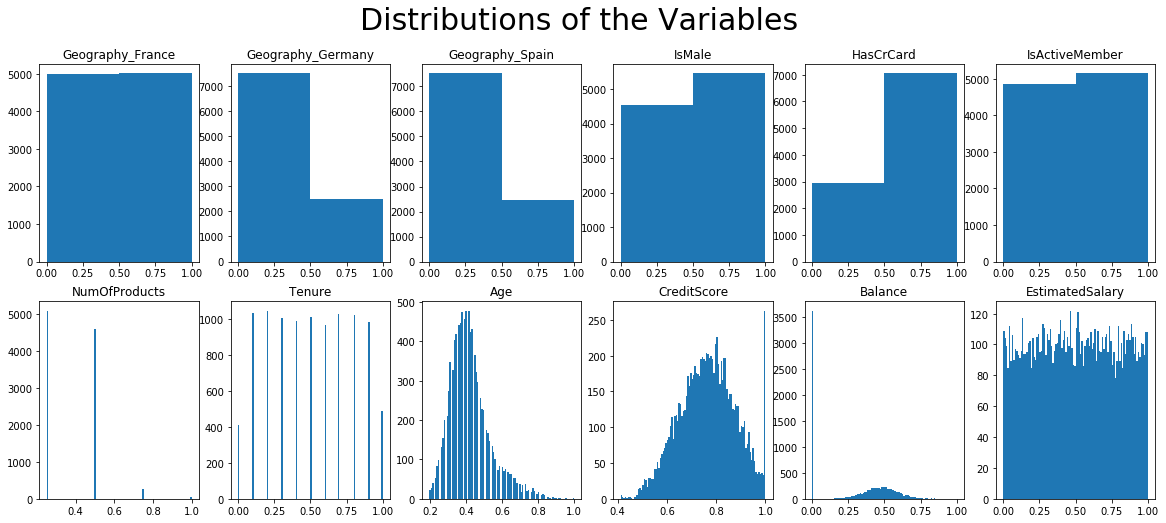

In [31]:
list_binary = [0,1,2,4,9,10]
list_normal = [3,5,6,7,8,11]

order = [0,1,2,4,9,10,8,6,5,3,7,11]

fig=plt.figure(figsize=(20,8))
for i in range(len(order)):
    xi = X[:,order[i]]
    ax1 = fig.add_subplot(2,len(order)/2,i+1)
    plt.title(list(bank_data)[order[i]],size=12)
    if i<6:
        plt.hist(xi,2)
    else:
        plt.hist(xi,100)
plt.suptitle('Distributions of the Variables',fontsize=30)
plt.show()

### 1.2 Relation Between the Variables

Relating the variables is not an easy task, since we have to handle both categorical and continuous variables. The main problem comes because the usual Pearson Correlation becomes misleading when the pairs of variables are away from bivariate normality (like it is clearly our case).

Other alternatives may be more suitable for this problem, like discretizing all the variables and calculating the mutual information (https://stats.stackexchange.com/questions/29489/how-do-i-study-the-correlation-between-a-continuous-variable-and-a-categorical).

However, since the results are still somewhat meaninful (with a cautious interpretation), we will still use the classical correlation matrix.

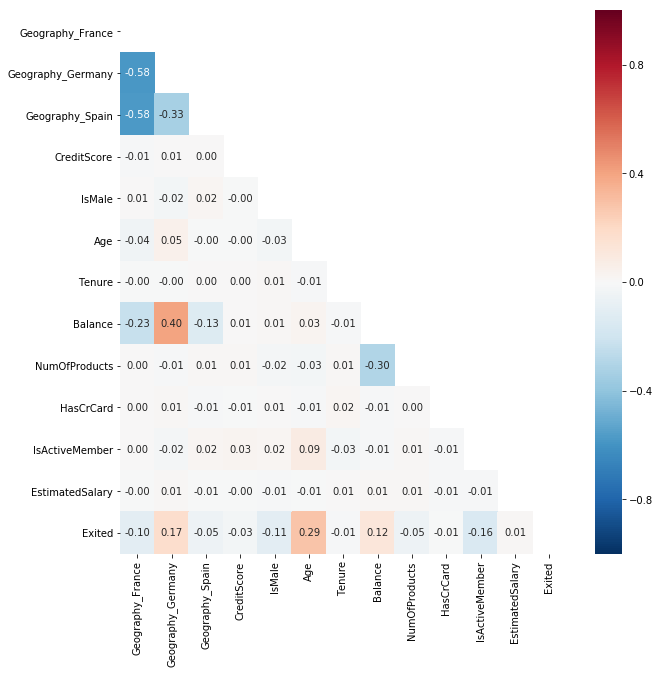

In [34]:
fig=plt.figure(figsize=(10,10))
CX=bank_data.corr()
mask = np.zeros_like(CX, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat=sb.heatmap(CX,mask=mask,annot=True, vmin=-1, vmax=1, fmt='.2f',cmap='RdBu_r')
fig.add_subplot(heat)
plt.show()

**Valuable Information about the Variables**